## Effect of climate change on ski resorts in Harz (Snow fall) (ski resort Wurmberg)
### Goal : - Calculate the number of working days (Resort open for public) effected by climate change 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import openmeteo_requests
import requests_cache
from retry_requests import retry
from sklearn.metrics import mean_squared_error

In [2]:
# resuable code

cache_session = requests_cache.CachedSession('.cache', expire_after = 3600)
retry_session = retry(cache_session, retries = 5, backoff_factor = 0.2)
openmeteo = openmeteo_requests.Client(session = retry_session)

# Function for frequent use for houlrly data
#https://open-meteo.com/en/docs/historical-weather-api#start_date=1950-01-01&end_date=2023-12-31&hourly=&daily=temperature_2m_mean&timezone=Europe%2FBerlin&models=era5_seamless
def daily_open_meteo_data(start_date:str, end_date:str, lat:list, long:list, variable):
	url = "https://archive-api.open-meteo.com/v1/archive"
	params = {
	"latitude": lat,
	"longitude": long,
	"start_date":start_date,
	"end_date": end_date,
	"timezone": "Europe/Berlin",
	"daily": variable,
	"models": ["era5_seamless"]
	}
	responses = openmeteo.weather_api(url, params=params)
	response = responses[0]
	# Process daily data. The order of variables needs to be the same as requested.
	daily = response.Daily()
	daily_sum = daily.Variables(0).ValuesAsNumpy()

	daily_data = {"date": pd.date_range(
	start = pd.to_datetime(daily.Time(), unit = "s", utc = True),
	end = pd.to_datetime(daily.TimeEnd(), unit = "s", utc = True),
	freq = pd.Timedelta(seconds = daily.Interval()),
	inclusive = "left"
	)}
	daily_data["open_meteo"] = daily_sum

	daily_dataframe = pd.DataFrame(data = daily_data)
	if daily_dataframe.empty:
		return print("The daily limit reached")
	return daily_dataframe

def calculate_accuracy(original_data, predicted_data):
	#mbe = np.mean(predicted_data - original_data) (We are not using this)
	rmse = np.sqrt(mean_squared_error(original_data, predicted_data))
	correlation = np.corrcoef(original_data, predicted_data)[0, 1]

	# Print results
	#print(f"Mean Bias Error (MBE): {mbe}") (We are not using this)
	print(f"Root Mean Square Error (RMSE): {rmse}")
	print(f"Correlation: {correlation}")
	

# Function for frequent use for houlrly data
#https://open-meteo.com/en/docs/historical-weather-api#start_date=1950-01-01&end_date=2023-12-31&hourly=&daily=temperature_2m_mean&timezone=Europe%2FBerlin&models=era5_seamless
def Hourly_open_meteo_data(start_date:str, end_date:str, lat:list, long:list, variable):
	url = "https://archive-api.open-meteo.com/v1/archive"
	params = {
	"latitude": lat,
	"longitude": long,
	"start_date":start_date,
	"end_date": end_date,
	"timezone": "Europe/Berlin",
	"hourly": variable,
	"models": ["era5_seamless"]
	}
	responses = openmeteo.weather_api(url, params=params)
	response = responses[0]
	# Process daily data. The order of variables needs to be the same as requested.
	hourly = response.Hourly()
	hourly_snow_depth = hourly.Variables(0).ValuesAsNumpy()

	hourly_data = {"date": pd.date_range(
		start = pd.to_datetime(hourly.Time(), unit = "s", utc = True),
		end = pd.to_datetime(hourly.TimeEnd(), unit = "s", utc = True),
		freq = pd.Timedelta(seconds = hourly.Interval()),
		inclusive = "left"
	)}
	hourly_data["open_meteo"] = hourly_snow_depth

	hourly_dataframe = pd.DataFrame(data = hourly_data)

	if hourly_dataframe.empty:
		return print("The daily limit reached")
	return hourly_dataframe


#font size for graph
f_title = 14
f_other = 12
# plots
def plot_my_bargraph(length:int,breath:int,xaxis,yaxis,title:str,xlabel:str,ylabel:str, widthv=0.5, colorv='blue',xtick = False):
    plt.figure(figsize=(length, breath))
    plt.bar(xaxis, yaxis, width = widthv , color=colorv)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(axis='y')
    if xtick == True:
        plt.xticks(xaxis,rotation=45,fontsize=f_other)
    plt.tight_layout()
    plt.show()


# to plot the values on bars and complusory X ticks
def plot_my_bargraph_withnumbers(length:int,breath:int,xaxis,yaxis,title:str,xlabel:str,ylabel:str, widthv=0.5, colorv='blue'):
    plt.figure(figsize=(length, breath))
    plt.bar(xaxis, yaxis, width = widthv , color=colorv)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(axis='y')
    # for display values on bar
    for i, value in enumerate(yaxis):
        plt.text(xaxis[i], value + 1, str(value), ha='center', fontsize=9)
    plt.tight_layout()
    plt.xticks(xaxis,rotation=45,fontsize=f_other)
    plt.show() 
     

def convert_year_to_season_Snowdepth(dataframe, limit):
    dataframe['month'] = dataframe.index.month
    dataframe['year'] = dataframe.index.year

    dec_to_mar = dataframe.loc[dataframe['month'].isin([12, 1, 2, 3])] # selecing the Season span December to March

	#adjusting the year from december to march
    dec_to_mar['cold_year'] = dec_to_mar['year']
    dec_to_mar.loc[dec_to_mar['month'] == 12, 'cold_year'] += 1

    Snowdepth_above_threshold = dec_to_mar.loc[dec_to_mar['open_meteo'] >= limit]

    snowcover_days = Snowdepth_above_threshold.groupby('cold_year').size()

    return snowcover_days


def convert_year_to_season_WBT(dataframe, thershold):
    dataframe['month'] = dataframe.index.month
    dataframe['year'] = dataframe.index.year

    dec_to_mar = dataframe.loc[dataframe['month'].isin([12, 1, 2, 3])] # selcing the Season span

	#adjusting the year from december to march
    dec_to_mar['cold_year'] = dec_to_mar['year']
    dec_to_mar.loc[dec_to_mar['month'] == 12, 'cold_year'] += 1

    WBT_thershold = dec_to_mar.loc[dec_to_mar['open_meteo'] <= thershold]

	#Summing up the day, classified by 'cold years'
    WBT_underthersold_days =  WBT_thershold.groupby('cold_year').size()

    return WBT_underthersold_days


def Convert_the_data_into_10_year_avergae(Dataframe):
    bins = range(1950, 2030, 10)  # Decade bins
    Dataframe.index = Dataframe.index.astype(int) 

    # Sum the total cold days for each decade and divide by 10
    averrage_days_by_decade = (Dataframe.groupby(pd.cut(Dataframe.index, bins)).sum() / 10) #Change the method for the Decade calculation.
    averrage_days_by_decade.index = averrage_days_by_decade.index.astype(str)
    return averrage_days_by_decade



In [3]:
# Getting the snow fall data from1 1950 to 2023
ski_resort_Wurmberg_snow_depth_hourly = Hourly_open_meteo_data("1950-01-01", "2023-12-31",[51.75], [10.61],"snow_depth")
ski_resort_Wurmberg_snow_depth_hourly

,date,open_meteo
0,1949-12-31 23:00:00+00:00,NaN
1,1950-01-01 00:00:00+00:00,NaN
2,1950-01-01 01:00:00+00:00,0.0
3,1950-01-01 02:00:00+00:00,0.0
4,1950-01-01 03:00:00+00:00,0.0
...,...,...
648667,2023-12-31 18:00:00+00:00,0.0
648668,2023-12-31 19:00:00+00:00,0.0
648669,2023-12-31 20:00:00+00:00,0.0
648670,2023-12-31 21:00:00+00:00,0.0


In [4]:
# Converting it into daily data 
ski_resort_Wurmberg_snow_depth_hourly.set_index('date',inplace = True)
ski_resort_Wurmberg_snow_depth_hourly.fillna(0,inplace=True) # to be sure it do not contain NAN values
ski_resort_Wurmberg_snow_depth_daily = ski_resort_Wurmberg_snow_depth_hourly.resample("D").mean()

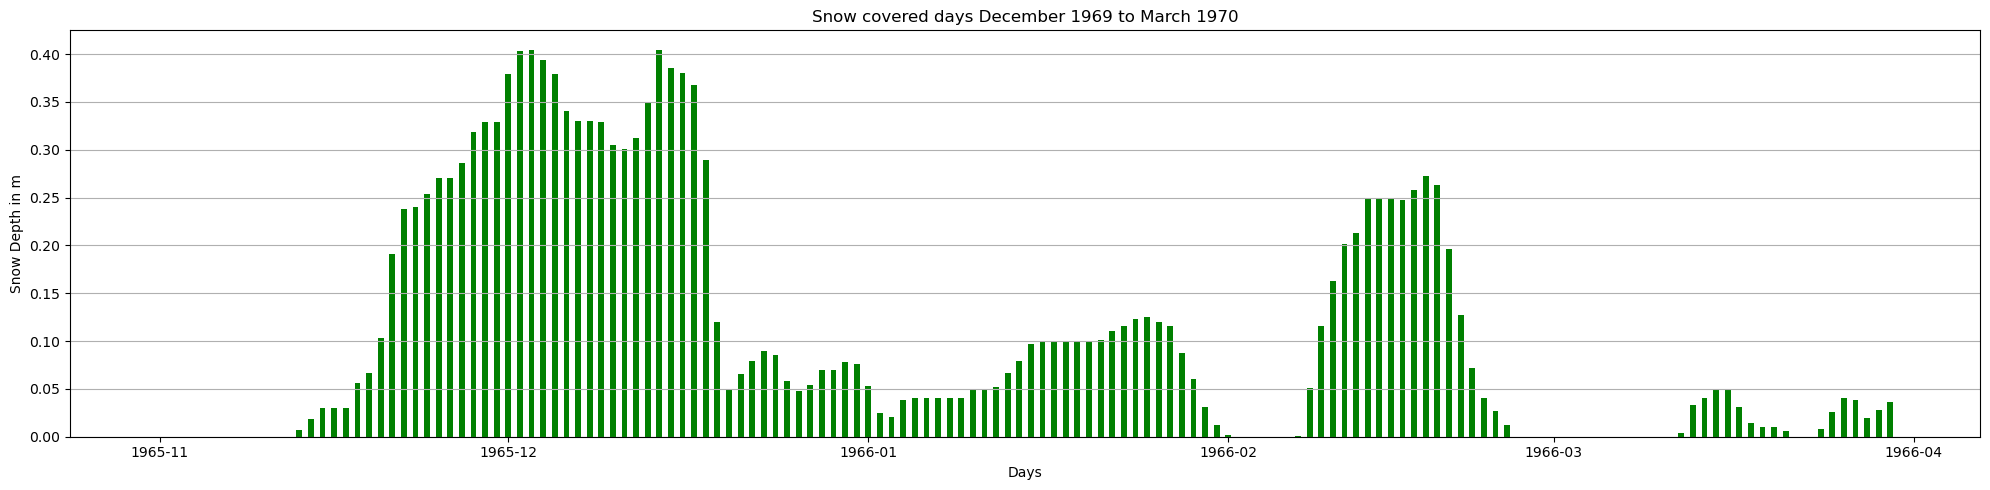

In [5]:
#Cheking the snow in one winter season
SRW_snow_depth_daily_season_1970 = ski_resort_Wurmberg_snow_depth_daily.loc["1965-11-01":"1966-03-30"]
plot_my_bargraph(20,5,SRW_snow_depth_daily_season_1970.index,SRW_snow_depth_daily_season_1970['open_meteo'], 'Snow covered days December 1969 to March 1970' ,'Days' ,'Snow Depth in m', colorv='green')
# SRW_snow_depth_daily_season_1970

### Ploting the Days snow available from 1950 to 1989

In [6]:
SRW_snow_depth_1950_1990 = ski_resort_Wurmberg_snow_depth_daily.loc["1950-01-01":"1989-04-30"]

In [7]:
# color option for matplot lib = ['lightblue', 'blue', 'purple', 'red', 'black', 'red', 'orange', 'darkblue', 'darkred', 'yellow'] 

C:\Users\rande\AppData\Local\Temp\ipykernel_12788\1682172735.py:118: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['month'] = dataframe.index.month
C:\Users\rande\AppData\Local\Temp\ipykernel_12788\1682172735.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['year'] = dataframe.index.year
C:\Users\rande\AppData\Local\Temp\ipykernel_12788\1682172735.py:124: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexe

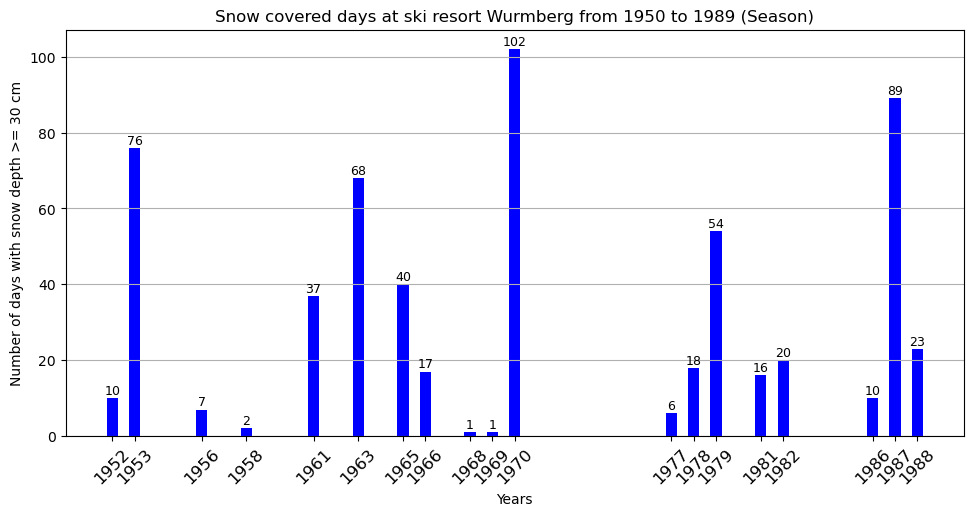

In [8]:
SRW_snow_days_1950_1990 = convert_year_to_season_Snowdepth(SRW_snow_depth_1950_1990, 0.3)
plot_my_bargraph_withnumbers(10,5,SRW_snow_days_1950_1990.index,SRW_snow_days_1950_1990.values, 'Snow covered days at ski resort Wurmberg from 1950 to 1989 (Season)' ,'Years' ,'Number of days with snow depth >= 30 cm', colorv='blue')

### Ploting the Days snow available from 1990 to 2023

In [9]:
SRW_snow_depth_1989_2023 = ski_resort_Wurmberg_snow_depth_daily.loc["1989-11-01":"2024-04-30"]

C:\Users\rande\AppData\Local\Temp\ipykernel_12788\1682172735.py:118: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['month'] = dataframe.index.month
C:\Users\rande\AppData\Local\Temp\ipykernel_12788\1682172735.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['year'] = dataframe.index.year
C:\Users\rande\AppData\Local\Temp\ipykernel_12788\1682172735.py:124: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexe

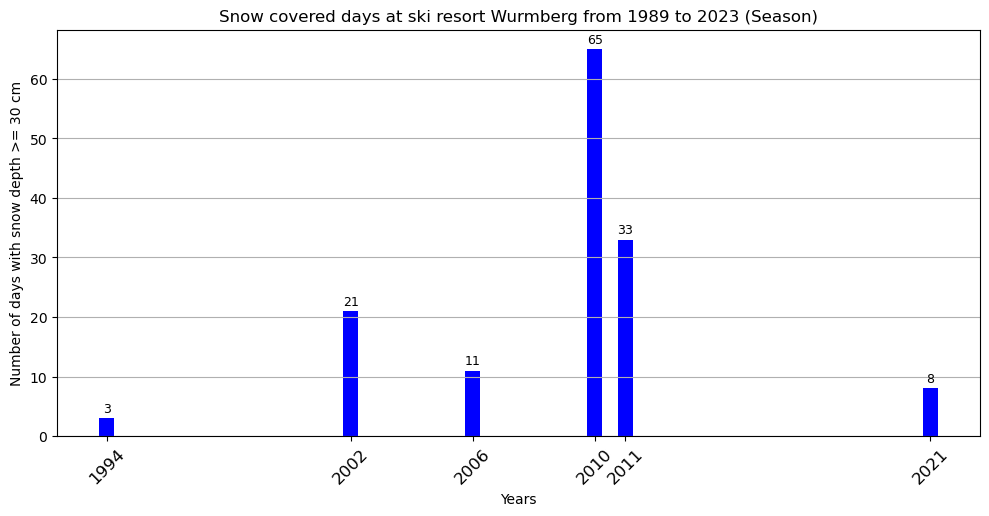

In [10]:
SRW_snow_days_1989_2023 = convert_year_to_season_Snowdepth(SRW_snow_depth_1989_2023,0.3)
plot_my_bargraph_withnumbers(10,5,SRW_snow_days_1989_2023.index,SRW_snow_days_1989_2023.values, 'Snow covered days at ski resort Wurmberg from 1989 to 2023 (Season)' ,'Years' ,'Number of days with snow depth >= 30 cm', colorv='blue')

### Checking the snow fall from 2010 to 2023

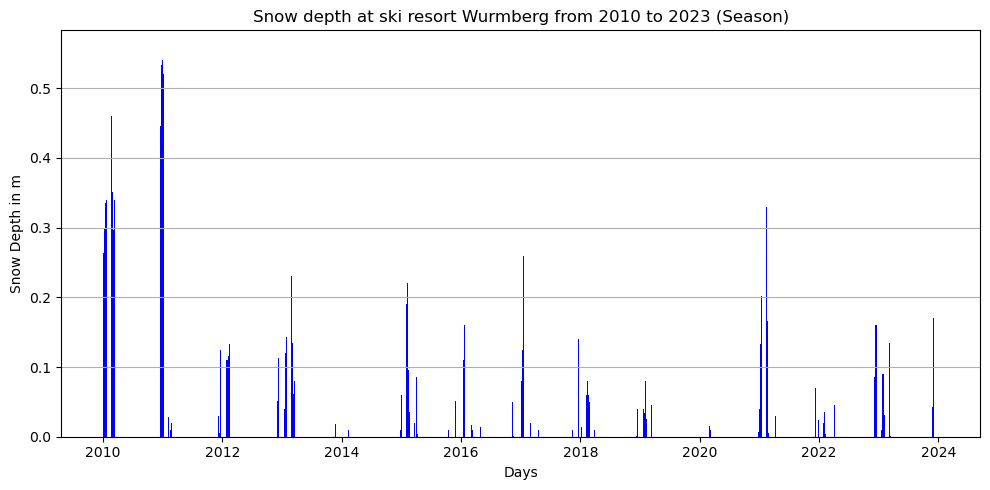

In [11]:
SRW_snow_depth_2010_2023 = ski_resort_Wurmberg_snow_depth_daily.loc["2010-01-01":"2023-12-31"]
plot_my_bargraph(10,5,SRW_snow_depth_2010_2023.index,SRW_snow_depth_2010_2023['open_meteo'], 'Snow depth at ski resort Wurmberg from 2010 to 2023 (Season)' ,'Days' ,'Snow Depth in m', colorv='blue')

### To better Visaulize the data we take 10 years average days for snow depth cover.

C:\Users\rande\AppData\Local\Temp\ipykernel_12788\1682172735.py:118: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['month'] = dataframe.index.month
C:\Users\rande\AppData\Local\Temp\ipykernel_12788\1682172735.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['year'] = dataframe.index.year
C:\Users\rande\AppData\Local\Temp\ipykernel_12788\1682172735.py:124: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexe

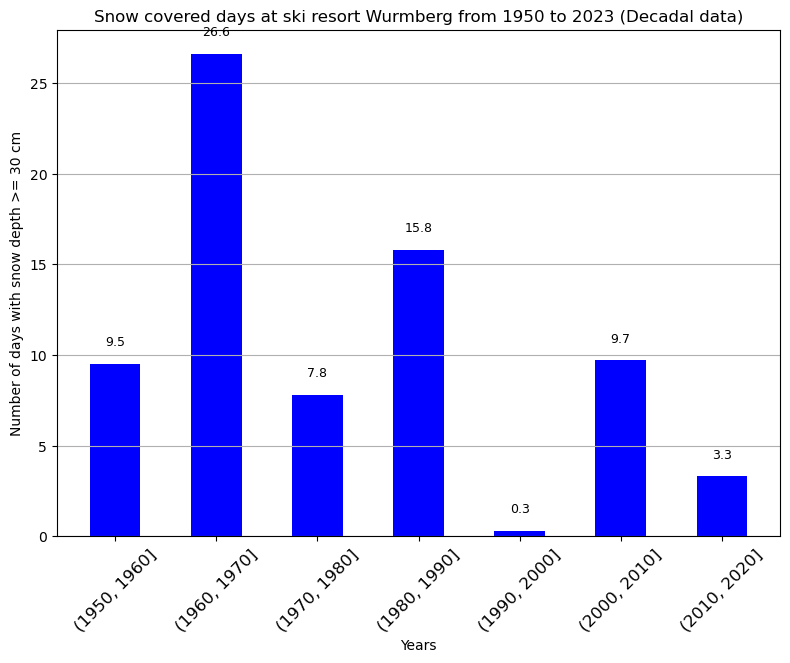

In [13]:
SRW_snow_depth_1950_2023 = ski_resort_Wurmberg_snow_depth_daily.loc["1950-01-01":"2024-04-30"]
SRW_snow_days_1950_2023 = convert_year_to_season_Snowdepth(SRW_snow_depth_1950_2023,0.3)
SRW_sd_1950_2023_10Years_avg = Convert_the_data_into_10_year_avergae(SRW_snow_days_1950_2023)
plot_my_bargraph_withnumbers(8,6,SRW_sd_1950_2023_10Years_avg.index,SRW_sd_1950_2023_10Years_avg.values, 'Snow covered days at ski resort Wurmberg from 1950 to 2023 (Decadal data)' ,'Years' ,'Number of days with snow depth >= 30 cm', colorv='blue')

## One of the main factor for artificall snow is WebBulbTempreature.
#### calculating days when the snow resort can generate the artifical snow when the bet_bulb tempreature is >= -2.5.
### WBT = wet bulb tempreture

In [14]:
#getting the wet bulb tempreture 
ski_resort_Wurmberg_WBT_hourly = Hourly_open_meteo_data("1950-01-01", "2023-12-31",[51.75], [10.61],"wet_bulb_temperature_2m")
ski_resort_Wurmberg_WBT_hourly

,date,open_meteo
0,1949-12-31 23:00:00+00:00,-8.681376
1,1950-01-01 00:00:00+00:00,-8.939520
2,1950-01-01 01:00:00+00:00,-5.797063
3,1950-01-01 02:00:00+00:00,-6.099465
4,1950-01-01 03:00:00+00:00,-6.340136
...,...,...
648667,2023-12-31 18:00:00+00:00,1.939361
648668,2023-12-31 19:00:00+00:00,1.665146
648669,2023-12-31 20:00:00+00:00,1.248783
648670,2023-12-31 21:00:00+00:00,1.052937


In [15]:
# Converting it into daily data 
ski_resort_Wurmberg_WBT_hourly.set_index('date',inplace = True)
ski_resort_Wurmberg_WBT_hourly.fillna(0,inplace=True) # to be sure it do not contain NAN values
ski_resort_Wurmberg_WBT_daily = ski_resort_Wurmberg_WBT_hourly.resample("D").mean()

## Converting the data into seasonal time interval and ploting the days available for artifical snow creation.

C:\Users\rande\AppData\Local\Temp\ipykernel_12788\1682172735.py:135: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['month'] = dataframe.index.month
C:\Users\rande\AppData\Local\Temp\ipykernel_12788\1682172735.py:136: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['year'] = dataframe.index.year
C:\Users\rande\AppData\Local\Temp\ipykernel_12788\1682172735.py:141: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexe

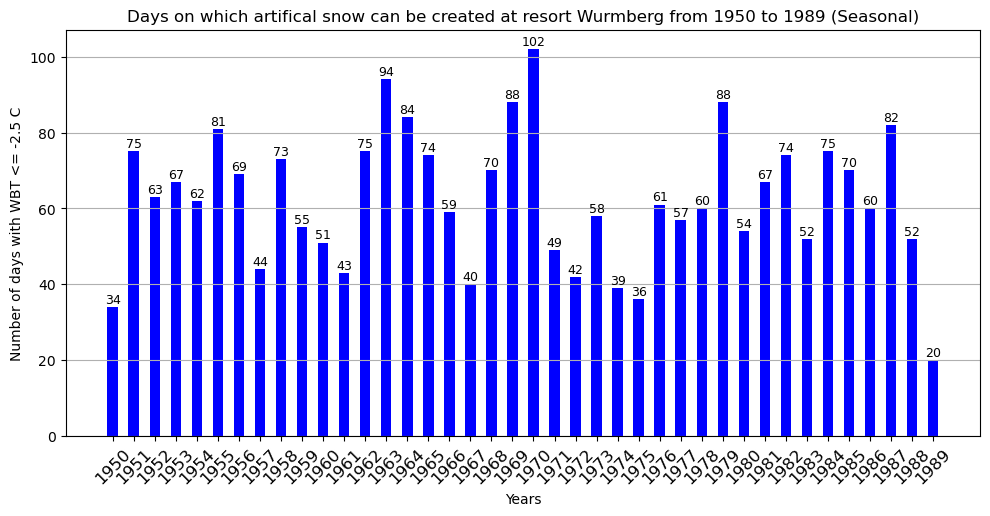

In [16]:
SRW_WBT_1950_1989 = ski_resort_Wurmberg_WBT_daily.loc["1950-01-01":"1989-04-30"]
WBT_days_for_Asnow_1950_1989 = convert_year_to_season_WBT(SRW_WBT_1950_1989, -2.5)
plot_my_bargraph_withnumbers(10,5,WBT_days_for_Asnow_1950_1989.index,WBT_days_for_Asnow_1950_1989.values, 'Days on which artifical snow can be created at resort Wurmberg from 1950 to 1989 (Seasonal)' ,'Years' ,'Number of days with WBT <= -2.5 C', colorv='blue')

#### For better visiualization converting it into average of Decades 

C:\Users\rande\AppData\Local\Temp\ipykernel_12788\1682172735.py:135: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['month'] = dataframe.index.month
C:\Users\rande\AppData\Local\Temp\ipykernel_12788\1682172735.py:136: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['year'] = dataframe.index.year
C:\Users\rande\AppData\Local\Temp\ipykernel_12788\1682172735.py:141: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexe

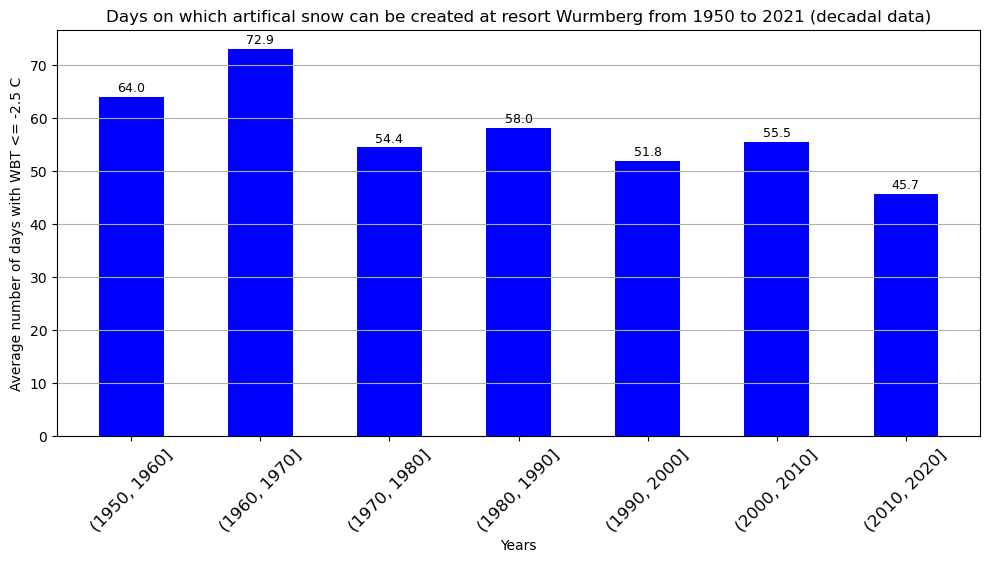

In [18]:
SRW_WBT_1950_2023 = ski_resort_Wurmberg_WBT_daily.loc["1950-01-01":"2024-04-30"]
WBT_days_for_Asnow_1950_2023 = convert_year_to_season_WBT(SRW_WBT_1950_2023,-2.5)
WBT_ASNOW_1950_2023_10Years_avg = Convert_the_data_into_10_year_avergae(WBT_days_for_Asnow_1950_2023)
plot_my_bargraph_withnumbers(10,5,WBT_ASNOW_1950_2023_10Years_avg.index,WBT_ASNOW_1950_2023_10Years_avg.values, 'Days on which artifical snow can be created at resort Wurmberg from 1950 to 2021 (decadal data)' ,'Years' ,'Average number of days with WBT <= -2.5 C', colorv='blue')